In [30]:
import csv
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from random import randint
from time import sleep
from requests.exceptions import RequestException
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

In [44]:
def read_csv_from_url(url):
    # Define a session for HTTP requests
    session = requests.Session()

    # Define the retry settings: total=5 will attempt the request up to 5 times
    # status_forcelist=[500, 502, 503, 504] will retry if one of these status codes is returned
    retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])

    # Mount the retry settings to the session
    session.mount("https://", HTTPAdapter(max_retries=retries))

    try:
        # Send the request and catch any exceptions
        response = session.get(url, timeout=10)
        
        # If the response was successful, parse it as CSV
        if response.status_code == 200:
            sleep(randint(1,5))
            data = response.content.decode('utf-8')
            return pd.read_csv(StringIO(data))
        else:
            print(f"Failed to download file from {url}, status code: {response.status_code}")
            return None
    except RequestException as e:
        print(f"Failed to download file: {e}")
        return None

In [9]:
# Load your shapefile
basin_shape = gpd.read_file('/home/yhuang21/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp')

# Load reservoir data from Bureau of Reclamation
reservoir_metadata = read_csv_from_url('https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv') 

In [11]:
# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(reservoir_metadata['site_metadata.longi'], reservoir_metadata['site_metadata.lat'])]
reservoirs_gdf = gpd.GeoDataFrame(reservoir_metadata, geometry=geometry)
reservoirs_gdf.crs = "EPSG:4326"
basin_shape.crs = "EPSG:4326"

# Ensure that both GeoDataFrames have the same CRS before spatial join
basin_shape = basin_shape.to_crs(reservoirs_gdf.crs)

# Perform spatial join
joined_gdf = gpd.sjoin(reservoirs_gdf, basin_shape, op='within')

# Filter by type_id and select relevant columns
reservoirs = joined_gdf[joined_gdf['datatype_id'] == 17][['site_metadata.lat', 'site_metadata.longi', 'site_metadata.site_name', 'site_id']]

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
# Remove duplicate rows
reservoirs = reservoirs.drop_duplicates().reset_index(drop=True)

# Rename Columns
reservoirs = reservoirs.rename(columns={'site_metadata.site_name':'name', 'site_metadata.lat':'lat', 'site_metadata.longi':'lon'})

In [43]:
reservoirs

,lat,lon,name,site_id
0,40.365100,-105.236000,Flatiron Reservoir nr Loveland,100081
1,40.320000,-105.210000,Carter Lake,100065
2,40.600000,-105.170000,Horsetooth Reservoir,100091
3,39.878317,-106.329748,GREEN MOUNTAIN RESERVOIR,100089
4,39.366647,-106.458926,HOMESTAKE RESERVOIR,100120
...,...,...,...,...
57,35.628230,-106.317160,COCHITI LAKE,2696
58,35.394720,-106.544720,JEMEZ CANYON RESERVOIR,2744
59,36.016300,-114.737400,Lake Mead,921
60,35.197900,-114.569400,Lake Mohave,922


In [71]:
# Check if reservoirs have more than one monitoring sites.
# We will keep only one monitoring site for each reservoir if the data from the monitoring sites are similar
if reservoirs['name'].nunique() != len(reservoirs):
    
    # Create a dictionary that stores reservoirs with more than one monitoring well
    repeated_reservoir = {}

    # Record the reservoir name and the row number where the record exists for such reservoir into a key value pair in a dictionary
    def collect_indexes(group):
        if len(group) > 1:
            repeated_reservoir[group.name] = group.index.tolist()
        
    reservoirs.groupby('name').apply(collect_indexes)
    
    print(repeated_reservoir)
else:
    print("All reservoirs have only one monitoring site for each.")

{'GRANBY RESERVOIR': [5, 46], 'GREEN MOUNTAIN RESERVOIR': [3, 47], 'SHADOW MOUNTAIN RESERVOIR': [7, 49, 52], 'WILLIAMS FORK RESERVOIR': [8, 50]}


/tmp/ipykernel_3514961/2631469203.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


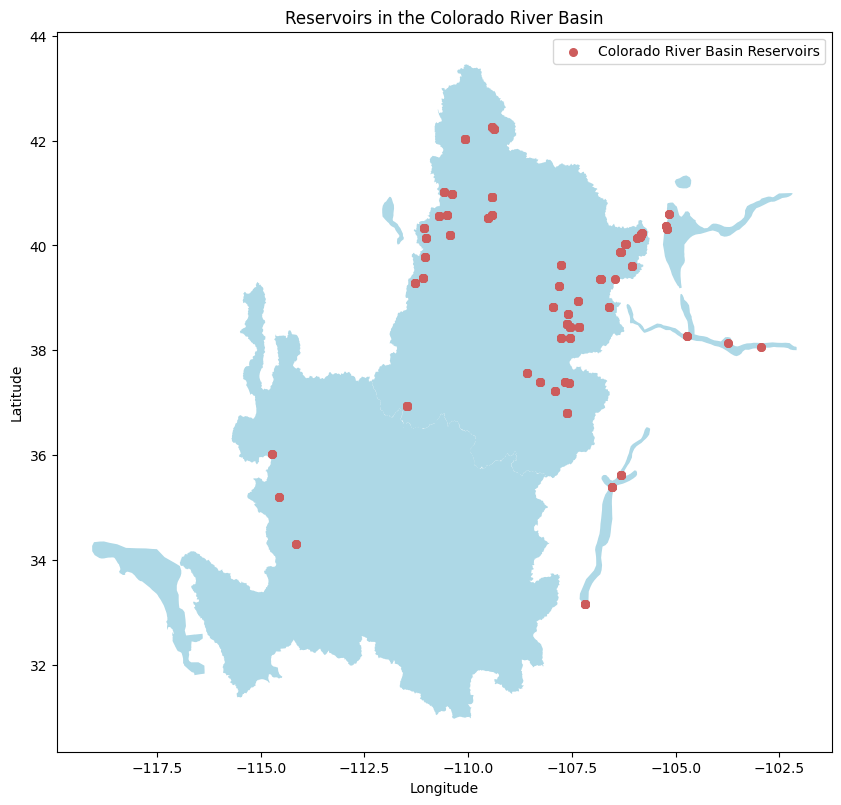

In [14]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='lightblue', label='Lower Basin')

# # Plot the reservoirs
joined_gdf.plot(ax=ax, marker='o', color='IndianRed', markersize=30, label='Colorado River Basin Reservoirs')

# # Add title and labels
plt.title('Reservoirs in the Colorado River Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()


In [45]:
# URL link to each reservoir's storage data
reclamation_url_head = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/'
reclamation_url_tail = '/csv/17.csv'

# Create an empty list to store all the temporary dataframes
data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in reservoirs.itertuples(index=False):
    lat, lon, name, id = row
    data = read_csv_from_url(reclamation_url_head + str(id) + reclamation_url_tail)
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.set_index('datetime')

    # Calculate the monthly average storage for each site
    data = data['storage'].resample('M').mean().reset_index()
    data['datetime'] = data['datetime'].dt.to_period('M')
    data['lat'] = lat
    data['lon'] = lon
    data['name'] = name

    #Store each dataframe of the monitoring sites into a list
    data_list.append(data)

In [73]:
# Initialize an empty list to record indices of redundant rows
rows_to_be_deleted = []

for name, rows in repeated_reservoir.items():
    # Within each list of indices, compare consecutive pairs of dataframes
    for i in range(len(rows)-1):
        
        # Check if the 'storage' column of two dataframes are identical
        if data_list[rows[i]]['storage'].equals(data_list[rows[i+1]]['storage']):
            rows_to_be_deleted.append(rows[i+1])
        else:
            # If they are not identical, find the differences using the 'compare' method
            differences = data_list[rows[i]]['storage'].compare(data_list[rows[i+1]]['storage'])
            print(f"Different storage values found for {name} at indexes {rows[i]} and {rows[i+1]}:")
            print(differences)


Different storage values found for GRANBY RESERVOIR at indexes 5 and 46:
              self          other
836  369440.229871  369451.512903
854  484215.803333  484213.493333


In [74]:
# The difference is not large for Granby Reservoir, so we will only keep the data we obtained from the index 5 monitoring site
rows_to_be_deleted.append(46)

# Select only the dataframes that are not in the `rows_to_be_deleted` list
data_list_clean = [df for i, df in enumerate(data_list) if i not in rows_to_be_deleted]

# Concatenate the selected dataframes
storage_df = pd.concat(data_list_clean, ignore_index=True)

In [77]:
storage_df

,datetime,storage,lat,lon,name
0,1954-01,546.851852,40.3651,-105.2360,Flatiron Reservoir nr Loveland
1,1954-02,597.464286,40.3651,-105.2360,Flatiron Reservoir nr Loveland
2,1954-03,494.322581,40.3651,-105.2360,Flatiron Reservoir nr Loveland
3,1954-04,533.166667,40.3651,-105.2360,Flatiron Reservoir nr Loveland
4,1954-05,584.290323,40.3651,-105.2360,Flatiron Reservoir nr Loveland
...,...,...,...,...,...
35444,2023-03,575989.258065,34.2964,-114.1385,Lake Havasu
35445,2023-04,574471.330000,34.2964,-114.1385,Lake Havasu
35446,2023-05,575608.451613,34.2964,-114.1385,Lake Havasu
35447,2023-06,576639.360000,34.2964,-114.1385,Lake Havasu
